## Importing libraries

In [1]:
# Importing the relevant libraries
import numpy as np

from nltk import tokenize

from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.engine.topology import Layer, InputSpec
from keras.layers import Embedding, Input, Dense, Bidirectional, LSTM, Layer, GRU, TimeDistributed
from keras.models import Model
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.callbacks


import string
import re
import pandas as pd
import collections
import os
import time

import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

Using TensorFlow backend.


## Data Load

In [2]:
# We define a function to load the data
def load_data(path_to_dir, dataset):
    
    '''
    The loading procedure is different for the two datasets, therefore we add a parameter to the load 
    function that specifies the dataset to load
    '''
    
    # Regular Expression to remove punctuation
    Remove_punctuation = re.compile('[%s]' % re.escape(string.punctuation.replace('.',''))) #We leave the periods in since we want to split it into sentences
    
    if dataset == "imdb":
        
        train_pos = []
        train_neg = []
        test_pos = []
        test_neg = []

        for filename in os.listdir(path_to_dir+"/train/pos/"):
            train_pos.append(open(path_to_dir+"/train/pos/"+filename,'r',encoding='utf-8').read())

        for filename in os.listdir(path_to_dir+"/train/neg/"):
            train_neg.append(open(path_to_dir+"/train/neg/"+filename,'r',encoding='utf-8').read())

        for filename in os.listdir(path_to_dir+"/test/pos/"):
            test_pos.append(open(path_to_dir+"/test/pos/"+filename,'r',encoding='utf-8').read())

        for filename in os.listdir(path_to_dir+"/test/neg/"):
            test_neg.append(open(path_to_dir+"/test/neg/"+filename,'r',encoding='utf-8').read())
        
        train_pos = [Remove_punctuation.sub('',i).lower() for i in train_pos]
        train_neg = [Remove_punctuation.sub('',i).lower() for i in train_neg]
        test_pos = [Remove_punctuation.sub('',i).lower() for i in test_pos]
        test_neg = [Remove_punctuation.sub('',i).lower() for i in test_neg]
        
        #train_pos = [[sent for sent in review if len(sent)!=0] for review in train_pos]
        #train_neg = [[sent for sent in review if len(sent)!=0] for review in train_pos]
        #test_pos = [[sent for sent in review if len(sent)!=0] for review in train_pos]
        #test_neg = [[sent for sent in review if len(sent)!=0] for review in train_pos]
        
        X_train = train_pos + train_neg
        X_test = test_pos + test_neg
        
        Y_train = [1]*len(train_pos) + [0]*len(train_neg)
        Y_test = [1]*len(test_pos) + [0]*len(test_neg)        
        
        return X_train, Y_train, X_test, Y_test
        
    if dataset == "yelp":
        
        Train_data = pd.read_csv(path_to_dir + "Yelp_train_data.csv")
        Train_data = Train_data[Train_data['stars']!=3]
        
        X_train = Train_data['text']
        X_train = list(X_train)
        
        Y_train = Train_data['stars']
        Y_train = list(Y_train)
        Y_train = [0 if i <= 3 else 1 for i in Y_train]
        
        Test_data =  pd.read_csv(path_to_dir + "Yelp_test_data.csv")
        Test_data = Test_data[Test_data['stars']!=3]
        
        X_test = Test_data['text']
        X_test = list(X_test)
        
        Y_test = Test_data['stars']
        Y_test = list(Y_test)
        Y_test = [0 if i <=3 else 1 for i in Y_test]
        
        X_train = [Remove_punctuation.sub('',i).lower() for i in X_train]
        X_test = [Remove_punctuation.sub('',i).lower() for i in X_test]
        
        #X_train = [[sent for sent in review if len(sent)!=0] for review in X_train]
        #X_test = [[sent for sent in review if len(sent)!=0] for review in X_test]
               
        return X_train, Y_train, X_test, Y_test       


In [3]:
X_train, Y_train, X_test, Y_test = load_data('../../../Data/IMDB Stanford/', "imdb")

## Data Pre Processing

In [4]:
# Converting the reviews into sentences
X_train_sentences = [review.split('.') for review in X_train]
X_train_sentences = [[sentence for sentence in review if len(sentence)!=0] for review in X_train_sentences]

X_test_sentences = [review.split('.') for review in X_test]
X_test_sentences = [[sentence for sentence in review if len(sentence)!=0] for review in X_test_sentences]



In [5]:
# Converting the words into tokens

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [6]:
# Setting up parameters for the word embeddings

Max_Words = 20000 #Max words in the vocabulary
Max_Sequence_length = 100 #Max number of words in a sentence
Embedding_dimension = 100 #Using 100 dimensional Glove data
Max_Sentence_length = 15


In [7]:
# Converting the words into tokens

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

print('Total %s unique tokens.' % len(word_index))

Total 107359 unique tokens.


In [8]:
Train_data = np.zeros((len(X_train), Max_Sentence_length, Max_Sequence_length), dtype='int32')
#(Number of reviews, number of sentences per review = 15, number of words per sentence = 100)

for i, sentences in enumerate(X_train_sentences):#Taking a single review(list of sentences) from a list of reviews
    for j, sent in enumerate(sentences):#Iterating through sentences within a review. sent = a sentence in a single review
        if j < Max_Sentence_length:
            wordTokens = text_to_word_sequence(sent)#Converting sentences into words(similar function to .split())
            #wordTokens is a list
            k = 0
            for _, word in enumerate(wordTokens):#Iterate through each word in the word token
                if k < Max_Sequence_length and tokenizer.word_index[word] < Max_Words:
                    Train_data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1
                    
Test_data = np.zeros((len(X_test), Max_Sentence_length, Max_Sequence_length), dtype='int32')

for i, sentences in enumerate(X_test_sentences):#Taking a single review(list of sentences) from a list of reviews
    for j, sent in enumerate(sentences):#Iterating through sentences within a review. sent = a sentence in a single review
        if j < Max_Sentence_length:
            wordTokens = text_to_word_sequence(sent)#Converting sentences into words(similar function to .split())
            #wordTokens is a list
            k = 0
            for _, word in enumerate(wordTokens):#Iterate through each word in the word token
                if k < Max_Sequence_length and tokenizer.word_index.get(word,0) < Max_Words:
                    Test_data[i, j, k] = tokenizer.word_index.get(word,0)
                    k = k + 1


In [9]:
# Creating the labels
Train_labels = np.array(Y_train)
Test_labels = np.array(Y_test)

In [10]:
# Splitting the training data into train and validation sets

Validation_set_frac = 0.2

Indices = np.arange(Train_data.shape[0])
np.random.shuffle(Indices)

X_train = Train_data[Indices]
Y_train = Train_labels[Indices]

Val_sample_size = int(Validation_set_frac*Train_data.shape[0]) # We use 20% of data for validation

X_train = X_train[:-Val_sample_size]
Y_train = Y_train[:-Val_sample_size]

X_val = X_train[-Val_sample_size:]
Y_val = Y_train[-Val_sample_size:]

print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)


(20000, 15, 100) (20000,) (5000, 15, 100) (5000,)


## Feature Engineering

In [11]:
# Loading the glove vector data

embedding_dict = {}
glove_file = open('../../../Data/Glove Data/glove.6B.100d.txt',encoding='utf8')
for line in glove_file:
    values = line.split()
    word = values[0]
    word_vec = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = word_vec
glove_file.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embedding_dict))

Total 400000 word vectors in Glove 6B 100d.


In [12]:
# Creating an embedding layer with weights as glove vector embeddings

weights = np.random.random((len(word_index) + 1, 100))

for word, i in word_index.items():
    word_vec = embedding_dict.get(word)
    if word_vec is not None:
        # words not found in embedding index will be all-zeros.
        weights[i] = word_vec

Embedding_input = Embedding(len(word_index) + 1, 100,weights=[weights], input_length=Max_Sequence_length,trainable=False)

## HAN Model

In [24]:
# HAN Model

'''The HAN Model is implemented using the functional model APIs from Keras'''

# We first build a custome keras layer that acts as an attention layer to calculate the importance of words within a sentence and 
# sentences within a review

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)



class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Note: The layer has been tested with Keras 1.x
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        #self.built = True
        super(Attention, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

Input_layer_sentence = Input(shape=(Max_Sequence_length,), dtype='int32')
Embedding_layer = Embedding_input(Input_layer_sentence)
LSTM_layer = Bidirectional(GRU(100, return_sequences=True))(Embedding_layer)
Attention_layer_word = Attention()(LSTM_layer)
Sentence_Encoder_layer = Model(Input_layer_sentence, Attention_layer_word)

Input_layer_review = Input(shape=(Max_Sentence_length, Max_Sequence_length), dtype='int32')
Review_Encoder_layer = TimeDistributed(Sentence_Encoder_layer)(Input_layer_review)
LSTM_layer_sentence = Bidirectional(GRU(100, return_sequences=True))(Review_Encoder_layer)
#l_dense_sent = TimeDistributed(Dense(200))(l_lstm_sent)
Attention_layer_sentence = Attention()(LSTM_layer_sentence)
Output_layer = Dense(1, activation='sigmoid')(Attention_layer_sentence)

HAN_model = Model(inputs=Input_layer_review,outputs=Output_layer)

HAN_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# Creating callback to measure time per epoch during training
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

Time_callback = TimeHistory()

# Creating a callback for Earlystopping
Early_Stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [26]:
HAN_Training = HAN_model.fit(X_train,Y_train, validation_data = (X_val, Y_val), epochs = 20, batch_size = 500, callbacks = [Time_callback, Early_Stopping])


Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 28s 1ms/step - loss: 0.7182 - acc: 0.5039 - val_loss: 0.6872 - val_acc: 0.5028
Epoch 2/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.6735 - acc: 0.6112 - val_loss: 0.6478 - val_acc: 0.6760
Epoch 3/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.5714 - acc: 0.7152 - val_loss: 0.5029 - val_acc: 0.7590
Epoch 4/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.4723 - acc: 0.7773 - val_loss: 0.4607 - val_acc: 0.7818
Epoch 5/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.4180 - acc: 0.8107 - val_loss: 0.4035 - val_acc: 0.8220
Epoch 6/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.3938 - acc: 0.8238 - val_loss: 0.3975 - val_acc: 0.8238
Epoch 7/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.3700 - acc: 0.8366 - val_loss: 0.3590 - val_acc:

In [27]:
# Saving the model to disk
HAN_model.save('HAN_model.h5')

# Saving the model configuration file to disk
HAN_model_json = HAN_model.to_json()
with open("HAN_model.json", "w") as json_file:
    json_file.write(HAN_model_json)

## Model Performance Metrics

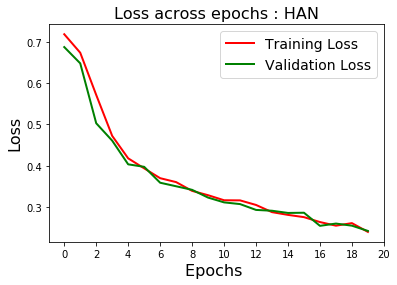

In [32]:
# Plotting the training/validation loss across epochs

figure1 = plt.figure()
plt.plot(HAN_Training.history['loss'],'r',linewidth=2.0)
plt.plot(HAN_Training.history['val_loss'],'g',linewidth=2.0)
epochs = list(range(1,len(Time_callback.times)+1))
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xticks(list(range(0,len(Time_callback.times)+1,2)))
#plt.ylim(0,0.6)
#plt.xlim(0,4)
plt.title('Loss across epochs : HAN',fontsize=16)
figure1.savefig('./Performance Graphs/HAN_model_Loss_Graph.png')
plt.show()

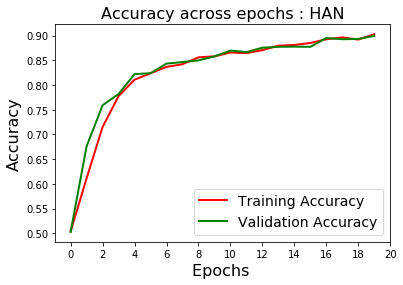

In [33]:
# Plotting the training/validation accuracy across epochs

figure2 = plt.figure()
plt.plot(HAN_Training.history['acc'],'r',linewidth=2.0)
plt.plot(HAN_Training.history['val_acc'],'g',linewidth=2.0)
epochs = list(range(1,len(Time_callback.times)+1))
plt.legend(['Training Accuracy','Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xticks(list(range(0,len(Time_callback.times)+1,2)))
#plt.ylim(0.4,1.0)
#plt.xlim(0,4)
plt.title('Accuracy across epochs : HAN',fontsize=16)
figure2.savefig('./Performance Graphs/HAN_model_Accuracy_Graph.png')
plt.show()

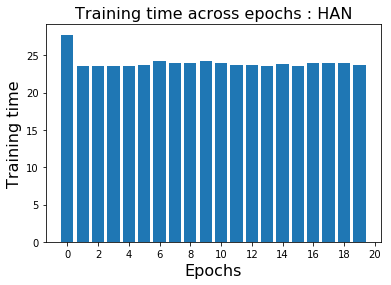

In [34]:
# Plotting the time taken per epoch

figure3 = plt.figure()
epochs = list(range(1,len(Time_callback.times)+1))
time_per_epoch = Time_callback.times
index = np.arange(len(epochs))

plt.bar(index, time_per_epoch)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training time', fontsize=16)
plt.xticks(list(range(0,len(epochs)+1,2)))
plt.title('Training time across epochs : HAN', fontsize = 16)
figure3.savefig('./Performance Graphs/HAN_model_Training_Time_Graph.png')
plt.show()
